<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/9x.ml_highspeed_networks/1.Training-and-testing-a-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import pickle # To save the model



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


from typing import List

--2020-05-23 14:33:59--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13008 (13K) [text/plain]
Saving to: ‘visualization.py.3’

visualization.py.3  100%[===================>]  12.70K  --.-KB/s    in 0s      

2020-05-23 14:34:00 (73.7 MB/s) - ‘visualization.py.3’ saved [13008/13008]



# Download the dataset and train/test split

Load the dataset

In [1]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2020-05-23 14:20:06--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.05s   

2020-05-23 14:20:10 (4.64 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2020-05-23 14:20:12--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connec

In [3]:
! ls

fulldataset.csv  lowdataset.csv  sample_data
highdataset.csv  __pycache__	 visualization.py


In [4]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

data = full_df.to_numpy()
print (data)

[[2.50873265e+01 1.83684800e+06 1.90327023e+08 ... 2.59473178e+08
  1.00265909e+02 0.00000000e+00]
 [2.51876032e+01 1.85564100e+06 1.90782590e+08 ... 2.59522865e+08
  1.00276024e+02 0.00000000e+00]
 [2.52878841e+01 1.85637300e+06 1.90688064e+08 ... 2.59533231e+08
  1.00281822e+02 0.00000000e+00]
 ...
 [5.97582917e+01 4.63221500e+06 1.75145145e+08 ... 2.59453245e+08
  1.00262788e+02 2.00000000e+00]
 [5.98585523e+01 4.64478900e+06 1.75105471e+08 ... 2.59444187e+08
  1.00259509e+02 2.00000000e+00]
 [5.99588178e+01 4.63646600e+06 1.75154689e+08 ... 2.59458785e+08
  1.00264199e+02 2.00000000e+00]]


In [5]:
full_df.head()

,time,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,branches,bus-cycles,cache-misses,cache-references,context-switches,cpu-clock,cycles,dTLB-load-misses,dTLB-store-misses,dTLB-stores,iTLB-load-misses,iTLB-loads,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,25.087326,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,105852681.0,9979685.0,597.0,450842.0,0.0,100.265610,259323485.0,1930.0,1003.0,116268401.0,2595.0,8.0,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,259473178.0,100.265909,0
1,25.187603,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,105824138.0,9979835.0,602.0,454711.0,0.0,100.276363,259527811.0,1968.0,1028.0,116231409.0,2557.0,0.0,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,259522865.0,100.276024,0
2,25.287884,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,105932173.0,9980286.0,657.0,451996.0,0.0,100.282061,259493612.0,1981.0,1040.0,116288889.0,2595.0,8.0,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,259533231.0,100.281822,0
3,25.388149,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,105974902.0,9983166.0,1374.0,454628.0,0.0,100.269016,259464166.0,2031.0,1015.0,116218953.0,2645.0,0.0,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,259571508.0,100.270504,0
4,25.488421,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,105931477.0,9978938.0,1325.0,452995.0,0.0,100.271755,259535337.0,2018.0,978.0,116317169.0,2914.0,0.0,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,259490859.0,100.270495,0


In [6]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 33)
Possible labels  [0 1 2]


In [7]:
def train_validation_test_splits(data, train_size, validation_size):
    assert(train_size + validation_size < 1.0)
    # shuffling of the dataset
    np.random.shuffle(data)
    # extract the training portion
    n = int(train_size * len(data))
    train, rest = data[:n,:], data[n:,:]
    # from the remaining examples, we extract the validation and test portions
    n = int(validation_size * len(data))
    validation, test = rest[:n,:], rest[n:,:]
    return train, validation, test

train, validation, test = train_validation_test_splits(data, 0.8, 0.1)

print('The number of examples in the original dataset is ' + str(data.shape[0]))

print('The training-set has ' + str(train.shape[0]) + ' examples')
print('The validation-set has ' + str(validation.shape[0]) + ' exampels')
print('The test-set has ' + str(test.shape[0]) + ' examples')
print('The shape of train is ' + str(train.shape)) 

The number of examples in the original dataset is 5824
The training-set has 4659 examples
The validation-set has 582 exampels
The test-set has 583 examples
The shape of train is (4659, 33)


# Pre-processing

In [0]:
# We separate the last column in 
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

validation_x, validation_y = np.hsplit(validation, [validation.shape[1] - 1])
validation_y = validation_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [0]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
validation_x = (validation_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [22]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/'

Mounted at /content/gdrive


# Logistic Regression

Normalized confusion matrix
[[0.985      0.005      0.01      ]
 [0.22285714 0.72571429 0.05142857]
 [0.13461538 0.14423077 0.72115385]]
The accuracy is  0.8130360205831904


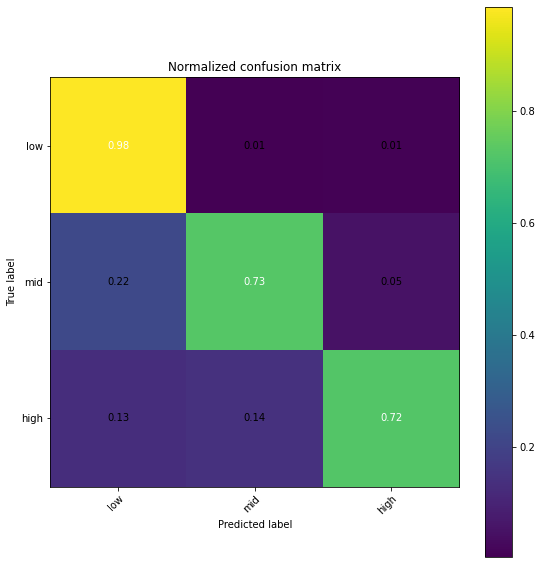

In [18]:
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=600)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
class_names = np.array(["low", "mid", "high"] )
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

Save the model

In [0]:
dump_file = open(my_path+"logistic-reg.pkl", "wb")
pickle.dump(model, dump_file)

# Your model

Train your models here and dump (i.e., save) them.